#LIBRARIES IMPORT, FUNCTION DEFINITION AND DATA LOADING

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
"""
LIBRARIES IMPORT AND CONSTANTS DEFINITION
A seed is used to make training-validation split reproducible.
"""

import os

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend #for clearing gpu and memory
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50V2, ResNet50
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = '/content/gdrive/My Drive/Quintavalla/'
DATA_FOLDER = BASE_DIR + "numpy data"
MODELS_FOLDER = BASE_DIR + "models"

MAX_UINT16 = 65535
VALIDATION_SPLIT = 0.15
DEFAULT_NUMBER_OF_EPOCHS = 50
MAX_NUMBER_OF_EPOCHS = 1000
DEFAULT_BATCH_SIZE = 32
SEED = 21

os.environ["PYTHONHASHSEED"]=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
"""
FUNCTION DEFINITION: DATA LOADING
The following functions load training and test data from the respective files. A 
dimension is added for compatibility with Keras models (the only grayscale channel
is replicated three times). Since in this task baselines are not required, the 
corresponding images and labels are discarded. 
"""

def load_training_data():
  images = np.load(os.path.join(DATA_FOLDER, 'train_tensor.npy'))
  labels = np.load(os.path.join(DATA_FOLDER, 'train_labels.npy'))
  images = np.repeat(images[:, :, :, np.newaxis], 3, axis=3)
  not_baseline_indexes = np.where(labels != 0)
  return images[not_baseline_indexes], labels[not_baseline_indexes]

def load_test_data():
  images = np.load(os.path.join(DATA_FOLDER, 'public_test_tensor.npy'))
  labels = np.load(os.path.join(DATA_FOLDER, 'public_test_labels.npy'))
  images = np.repeat(images[:, :, :, np.newaxis], 3, axis=3)
  not_baseline_indexes = np.where(labels != 0)
  return images[not_baseline_indexes], labels[not_baseline_indexes]

In [ ]:
"""
FUNCTION DEFINITION: ACCURACY/LOSS PLOTTING
The following functions plot training vs. validation accuracy and training vs. 
validation loss.
"""

def plot_training_validation_accuracy(training_accuracy, validation_accuracy, tick):

  epochs = [ x+1 for x in range(len(training_accuracy)) ]

  plt.plot(epochs, training_accuracy, 'r', label="Training Accuracy")
  plt.plot(epochs, validation_accuracy, 'b', label="Validation Accuracy")
  plt.ylim(0, 1)
  plt.xticks(np.arange(min(epochs)-1, max(epochs)+1, tick))
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.show()

def plot_training_validation_loss(training_loss, validation_loss, tick):

  epochs = [ x+1 for x in range(len(training_loss)) ]

  plt.plot(epochs, training_loss, 'r', label="Training Loss")
  plt.plot(epochs, validation_loss, 'b', label="Validation Loss")
  plt.xticks(np.arange(min(epochs)-1, max(epochs)+1, tick))
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.show()

In [ ]:
"""
DATA LOADING
Data are loaded from files using functions defined above. 
"""

training_images, training_labels = load_training_data()
test_images, test_labels = load_test_data()

print(training_images.shape)
print(training_labels.shape)

print(test_images.shape)
print(test_labels.shape)

print(training_labels)
print(test_labels)

print(training_images.dtype)

print(training_images[0][0][0][0])
print(training_images[0][0][0][1])
print(training_images[0][0][0][2])

TRAINING_SET_SIZE = training_images.shape[0]
TEST_SET_SIZE = test_images.shape[0]
IMAGE_HEIGHT = training_images.shape[1]
IMAGE_WIDTH =  training_images.shape[2]
CHANNELS = training_images.shape[3]

(2676, 150, 150, 3)
(2676,)
(336, 150, 150, 3)
(336,)
[2 2 1 ... 4 4 3]
[2 2 2 2 1 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 1 1 1 1 2 2 1 1 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 2 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2
 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 1
 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 2 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 4 4 3 3 3 3
 3 3 4 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 3 4 4 3 3 4 4 4 4 4 4
 4 3 3 3 3 4 4 4 3 3 3 3 3 3 4 3 3 3 3 3 3 4 4 4 4 3 3 3 3 4 3 3 4 4 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 3 3 3 3 3 3 3
 3 3 3]
uint16
28072
28072
28072


#SUBTASK 1: PRE-TRAINED CALCIFICATION-MASS CLASSIFICATION
Since the problem is a binary classification, we need to distinguish between two classes. Label 0 is assigned to Calcification class (original labels were 3 and 4), label 1 is assigned to Mass class (original labels were 1 and 2). It is important to analyze the balancing of the two classes so that a countermeasure to a possible unbalanced class problem can be taken.

In [ ]:
"""
PREPROCESSING
Labels are redefined: label 0 is assigned to Calcification class, label 1 is assigned to Mass class.
Sets compositions are printed.
"""

cm_training_labels = np.array([0 if n > 2 else 1 for n in training_labels]) 
cm_test_labels = np.array([0 if n > 2 else 1 for n in test_labels]) 

print("TRAINING SET")
print("Number of samples of class 0 (Calcification): " + str(np.count_nonzero(cm_training_labels==0)) + 
      " (" + str(round((np.count_nonzero(cm_training_labels==0)/TRAINING_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Mass): " + str(np.count_nonzero(cm_training_labels==1)) + 
      " (" + str(round((np.count_nonzero(cm_training_labels==1)/TRAINING_SET_SIZE)*100,2)) + "%)")

print("TEST SET")
print("Number of samples of class 0 (Calcification): " + str(np.count_nonzero(cm_test_labels==0)) + 
      " (" + str(round((np.count_nonzero(cm_test_labels==0)/TEST_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Mass): " + str(np.count_nonzero(cm_test_labels==1)) + 
      " (" + str(round((np.count_nonzero(cm_test_labels==1)/TEST_SET_SIZE)*100,2)) + "%)")

TRAINING SET
Number of samples of class 0 (Calcification): 1458 (54.48%)
Number of samples of class 1 (Mass): 1218 (45.52%)
TEST SET
Number of samples of class 0 (Calcification): 157 (46.73%)
Number of samples of class 1 (Mass): 179 (53.27%)


##EXPERIMENT 1_1: FEATURE EXTRACTION FROM VGG16 AND RESNET50
The aim of this experiment is to evaluate the results of performing feature extraction from two of the most used pre-trained networks, *VGG16* and *ResNet50*. Both networks are considered without their top layers (*include_top=False*) and their weights are initialized according to the results of pre-training on *ImageNet*.  Both bases are *frozen*, so the only layers that will be trained are theones put on the top of those bases.

In [ ]:
"""
PREPROCESSING
Training and test images are normalized. Training images (and their respective labels) are 
shuffled because the parameter validation_split of model.fit function will take the last portion 
of the dataset as validation set. To the current state, images (and their labels) are ordered by 
class (the elements labelled as 0 are at the end of the set). Validation set composition is
printed, so that a new extraction can be performed in case of unbalanced classes.
"""

m1_1_training_images = training_images / MAX_UINT16
m1_1_training_labels = cm_training_labels

m1_1_test_images = test_images / MAX_UINT16
m1_1_test_labels = cm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m1_1_training_images = m1_1_training_images[permutation]  
m1_1_training_labels = m1_1_training_labels[permutation] 

m1_1_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))
m1_1_validation_labels = m1_1_training_labels[-m1_1_validation_size:]

print("VALIDATION SET")
print("Number of samples of class 0 (Calcification): " + str(np.count_nonzero(m1_1_validation_labels==0)) + 
      " (" + str(round((np.count_nonzero(m1_1_validation_labels==0)/m1_1_validation_size)*100,2)) + "%)")
print("Number of samples of class 1 (Mass): " + str(np.count_nonzero(m1_1_validation_labels==1)) + 
      " (" + str(round((np.count_nonzero(m1_1_validation_labels==1)/m1_1_validation_size)*100,2)) + "%)")

VALIDATION SET
Number of samples of class 0 (Calcification): 220 (54.86%)
Number of samples of class 1 (Mass): 181 (45.14%)


###VGG16-BASED
*VGG16* is used as base in this experiment. A *ReLu* Dense layer is added on the top the base, and another *Sigmoid* Dense layer is used to perform classification. *Adam* is used as optimizer and Learning Rate is 1e-5. Max number of epochs is 1000, but a *Callback* with *patience=15* is used.

In [ ]:
"""
VGG16-BASED MODEL 
"""

vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

#vgg base is frozen
vgg_base.trainable=False

model1_1_vgg = models.Sequential(name="MODEL_1_VGG")
model1_1_vgg.add(vgg_base)
model1_1_vgg.add(layers.Flatten(name="FLAT_1"))
model1_1_vgg.add(layers.Dense(1024, activation="relu", name="DENSE_1"))
model1_1_vgg.add(layers.Dense(1, activation="sigmoid", name="DENSE_2"))

model1_1_vgg.summary()

Model: "MODEL_1_VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
FLAT_1 (Flatten)             (None, 8192)              0         
_________________________________________________________________
DENSE_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
DENSE_2 (Dense)              (None, 1)                 1025      
Total params: 23,105,345
Trainable params: 8,390,657
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 1_1_VGG COMPILATION AND FITTING
Adam is used as optimizer, with Learning Rate equal to 1e-5. Max number of epochs
is 1000, Callback is used to early stop training phase. 
"""

model1_1_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_1_vgg_history  = model1_1_vgg.fit(x=m1_1_training_images,
          y=m1_1_training_labels,
          validation_split=VALIDATION_SPLIT, 
          batch_size=DEFAULT_BATCH_SIZE,
          epochs=MAX_NUMBER_OF_EPOCHS,
          callbacks=[callback])

Epoch 1/1000
72/72 [==============================] - 6s 81ms/step - loss: 0.6777 - accuracy: 0.5791 - val_loss: 0.6307 - val_accuracy: 0.7289
Epoch 2/1000
72/72 [==============================] - 6s 78ms/step - loss: 0.6261 - accuracy: 0.7168 - val_loss: 0.5997 - val_accuracy: 0.7463
Epoch 3/1000
72/72 [==============================] - 6s 79ms/step - loss: 0.5913 - accuracy: 0.7522 - val_loss: 0.5807 - val_accuracy: 0.7114
Epoch 4/1000
72/72 [==============================] - 6s 80ms/step - loss: 0.5754 - accuracy: 0.7791 - val_loss: 0.5708 - val_accuracy: 0.6542
Epoch 5/1000
72/72 [==============================] - 6s 80ms/step - loss: 0.5603 - accuracy: 0.7120 - val_loss: 0.5429 - val_accuracy: 0.8010
Epoch 6/1000
72/72 [==============================] - 6s 80ms/step - loss: 0.5304 - accuracy: 0.7919 - val_loss: 0.5300 - val_accuracy: 0.8085
Epoch 7/1000
72/72 [==============================] - 6s 80ms/step - loss: 0.5251 - accuracy: 0.7870 - val_loss: 0.5187 - val_accuracy: 0.8010

In [ ]:
"""
MODEL 1_1_VGG RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m1_1_vgg_test_loss, m1_1_vgg_test_accuracy = model1_1_vgg.evaluate(m1_1_test_images ,m1_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m1_1_vgg_test_accuracy))
print("LOSS " + str(m1_1_vgg_test_loss))

11/11 [==============================] - 1s 65ms/step - loss: 0.3472 - accuracy: 0.8512
TEST SET RESULTS
ACCURACY 0.851190447807312
LOSS 0.34718984365463257


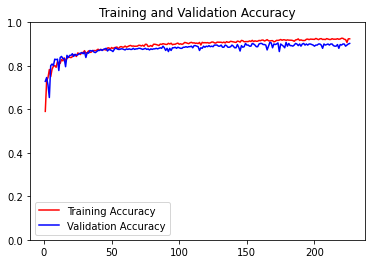

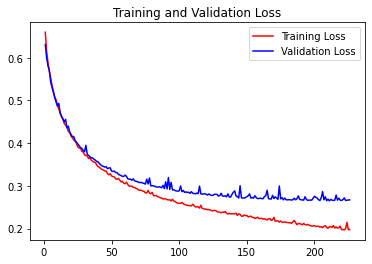

In [ ]:
"""
MODEL 1_1_VGG PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model1_1_vgg_history.history['accuracy'], model1_1_vgg_history.history['val_accuracy'], 50.0)

plot_training_validation_loss(model1_1_vgg_history.history['loss'], model1_1_vgg_history.history['val_loss'], 50.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m1_1_vgg_predicted_labels = [ int(x) for x in np.around(model1_1_vgg.predict(m1_1_test_images),0) ]

print(metrics.classification_report(m1_1_test_labels, m1_1_vgg_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m1_1_test_labels, m1_1_vgg_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m1_1_test_labels, m1_1_vgg_predicted_labels))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       157
           1       0.86      0.87      0.86       179

    accuracy                           0.85       336
   macro avg       0.85      0.85      0.85       336
weighted avg       0.85      0.85      0.85       336

CONFUSION MATRIX
[[131  26]
 [ 24 155]]
AUC SCORE
0.850158346084048


###RESNET50-BASED
ResNet50 is used as base in this experiment. In order to reduce the total number of parameters to be learned, a Global Pooling Layer is used instead of a Flatten one. A *ReLu* Dense layer is added on the top the base, and another *Sigmoid* Dense layer is used to perform classification. *Adam* is used as optimizer and Learning Rate is 1e-5. Max number of epochs is 1000, but a *Callback* with *patience=15* is used.

In [ ]:
"""
RESNET50-BASED MODEL 
"""

res_base = ResNet50V2(weights='imagenet',
                    include_top=False,
                    input_shape=(150,150,3))

res_base.trainable=False

#res base is frozen 
model1_1_res = models.Sequential(name="MODEL_1_RES")
model1_1_res.add(res_base)
model1_1_res.add(layers.GlobalAveragePooling2D(name="GLOB_AVG_1"))
model1_1_res.add(layers.Dense(1024, activation="relu", name="DENSE_1"))
model1_1_res.add(layers.Dense(1, activation="sigmoid", name="DENSE_2"))

model1_1_res.summary()

Model: "MODEL_1_RES"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
GLOB_AVG_1 (GlobalAveragePoo (None, 2048)              0         
_________________________________________________________________
DENSE_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
DENSE_2 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 1_1_RES COMPILATION AND FITTING
Adam is used as optimizer, with Learning Rate equal to 1e-5. Max number of epochs
is 1000, Callback is used to early stop training phase. 
"""

model1_1_res.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_1_res_history  = model1_1_res.fit(x=m1_1_training_images,
          y=m1_1_training_labels,
          validation_split=VALIDATION_SPLIT, 
          batch_size=DEFAULT_BATCH_SIZE,
          callbacks=[callback],
          epochs=MAX_NUMBER_OF_EPOCHS)

Epoch 1/1000
72/72 [==============================] - 7s 67ms/step - loss: 0.6823 - accuracy: 0.5324 - val_loss: 0.5679 - val_accuracy: 0.7114
Epoch 2/1000
72/72 [==============================] - 4s 56ms/step - loss: 0.5479 - accuracy: 0.7572 - val_loss: 0.5031 - val_accuracy: 0.7662
Epoch 3/1000
72/72 [==============================] - 4s 57ms/step - loss: 0.4970 - accuracy: 0.7766 - val_loss: 0.4656 - val_accuracy: 0.7761
Epoch 4/1000
72/72 [==============================] - 4s 57ms/step - loss: 0.4535 - accuracy: 0.8154 - val_loss: 0.4430 - val_accuracy: 0.7786
Epoch 5/1000
72/72 [==============================] - 4s 57ms/step - loss: 0.4246 - accuracy: 0.8301 - val_loss: 0.4257 - val_accuracy: 0.7836
Epoch 6/1000
72/72 [==============================] - 4s 58ms/step - loss: 0.3905 - accuracy: 0.8479 - val_loss: 0.4122 - val_accuracy: 0.7935
Epoch 7/1000
72/72 [==============================] - 4s 58ms/step - loss: 0.3744 - accuracy: 0.8552 - val_loss: 0.4027 - val_accuracy: 0.8060

In [ ]:
"""
MODEL 1_1_RES RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m1_1_res_test_loss, m1_1_res_test_accuracy = model1_1_res.evaluate(m1_1_test_images ,m1_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m1_1_res_test_accuracy))
print("LOSS " + str(m1_1_res_test_loss))

11/11 [==============================] - 1s 50ms/step - loss: 0.3964 - accuracy: 0.8452
TEST SET RESULTS
ACCURACY 0.8452380895614624
LOSS 0.39635440707206726


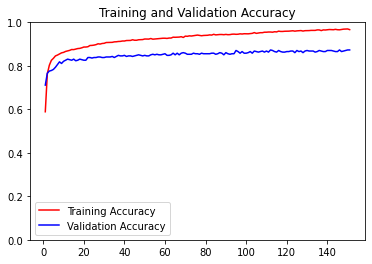

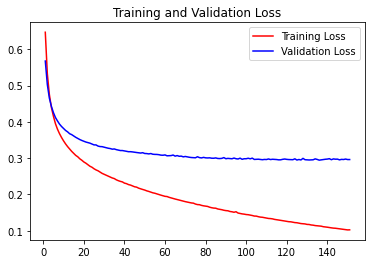

In [ ]:
"""
MODEL 1_1_RES PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model1_1_res_history.history['accuracy'], model1_1_res_history.history['val_accuracy'], 20.0)

plot_training_validation_loss(model1_1_res_history.history['loss'], model1_1_res_history.history['val_loss'], 20.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m1_1_res_predicted_labels = [ int(x) for  x in np.around(model1_1_res.predict(m1_1_test_images),0) ]

print(metrics.classification_report(m1_1_test_labels, m1_1_res_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m1_1_test_labels, m1_1_res_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m1_1_test_labels, m1_1_res_predicted_labels))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       157
           1       0.88      0.82      0.85       179

    accuracy                           0.85       336
   macro avg       0.85      0.85      0.85       336
weighted avg       0.85      0.85      0.85       336

CONFUSION MATRIX
[[137  20]
 [ 32 147]]
AUC SCORE
0.8469202576237412


###CONCLUSIONS
VGG16-based model is better than ResNet50 based and it will be used for the next experiment.

In [ ]:
"""
MODEL SAVING
Model is saved in model folder as 'calcification_mass_pretrained_vgg1'.
"""
model1_1_vgg.save(os.path.join(MODELS_FOLDER,"calcification_mass_pretrained_vgg1.h5"))

##EXPERIMENT 1_2: EXTRACT ONLY FIRST LAYERS FROM VGG16
Since *ImageNet* dataset is far different from *CBIS-DDSM* dataset, an idea could be to use only the first pretrained layers of *VGG16*. As a matter of fact, they extract only the most generic features that can be reused in the current problem. The extracted layers are *frozen*, so that learned features are not modified.

In [ ]:
"""
PREPROCESSING
Training and test images are normalized. Training images (and their respective labels) are 
shuffled because the parameter validation_split of model.fit function will take the last portion 
of the dataset as validation set. To the current state, images (and their labels) are ordered by 
class (the elements labelled as 0 are at the end of the set). Validation set composition is
printed, so that a new extraction can be performed in case of unbalanced classes.
"""

m1_2_training_images = training_images / MAX_UINT16
m1_2_training_labels = cm_training_labels

m1_2_test_images = test_images / MAX_UINT16
m1_2_test_labels = cm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m1_2_training_images = m1_2_training_images[permutation]  
m1_2_training_labels = m1_2_training_labels[permutation] 

m1_2_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))
m1_2_validation_labels = m1_2_training_labels[-m1_2_validation_size:]

print("VALIDATION SET")
print("Number of samples of class 0 (Calcification): " + str(np.count_nonzero(m1_2_validation_labels==0)) + 
      " (" + str(round((np.count_nonzero(m1_2_validation_labels==0)/m1_2_validation_size)*100,2)) + "%)")
print("Number of samples of class 1 (Mass): " + str(np.count_nonzero(m1_2_validation_labels==1)) + 
      " (" + str(round((np.count_nonzero(m1_2_validation_labels==1)/m1_2_validation_size)*100,2)) + "%)")

VALIDATION SET
Number of samples of class 0 (Calcification): 220 (54.86%)
Number of samples of class 1 (Mass): 181 (45.14%)


###VGG16-BASED
Only first four convolutional block are taken. A Convolutional layer and a Max Pooling layer are put on the top of the base. Finally, a ReLu Dense layer is added on the top the base, and another Sigmoid Dense layer is used to perform classification. Adam is used as optimizer and Learning Rate is 1e-5. Max number of epochs is 1000, but a Callback with patience=15 is used.


In [ ]:
"""
VGG16-BASED MODEL 
"""

vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

vgg_base.trainable = False

model1_2_vgg = models.Sequential(name="MODEL_2_VGG")

#take only first four Convolutional blocks
for layer in vgg_base.layers[:15]:
  model1_2_vgg.add(layer)

model1_2_vgg.add(layers.Conv2D(filters=512, kernel_size=(2,2), activation="relu", kernel_initializer="he_uniform", name="CONV_1"))
model1_2_vgg.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_1"))
model1_2_vgg.add(layers.Flatten(name="FLAT_1"))
model1_2_vgg.add(layers.Dense(1024, activation="relu", kernel_initializer="he_uniform", name="DENSE_1"))
model1_2_vgg.add(layers.Dense(1, activation="sigmoid", name="DENSE_2"))

model1_2_vgg.summary()

Model: "MODEL_1_VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       

In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 1_2_VGG COMPILATION AND FITTING
Adam is used as optimizer, with Learning Rate equal to 1e-6. Max number of epochs
is 1000, Callback is used to early stop training phase. 
"""

model1_2_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1_2_vgg_history  = model1_2_vgg.fit(x=m1_2_training_images,
          y=m1_2_training_labels,
          validation_split=VALIDATION_SPLIT, 
          batch_size=DEFAULT_BATCH_SIZE,
          epochs=MAX_NUMBER_OF_EPOCHS, 
          callbacks=[callback])

Epoch 1/1000
72/72 [==============================] - 6s 82ms/step - loss: 1.3778 - accuracy: 0.4746 - val_loss: 0.6447 - val_accuracy: 0.6716
Epoch 2/1000
72/72 [==============================] - 6s 78ms/step - loss: 0.6463 - accuracy: 0.6352 - val_loss: 0.5833 - val_accuracy: 0.7189
Epoch 3/1000
72/72 [==============================] - 6s 79ms/step - loss: 0.5729 - accuracy: 0.7047 - val_loss: 0.5404 - val_accuracy: 0.7662
Epoch 4/1000
72/72 [==============================] - 6s 80ms/step - loss: 0.5439 - accuracy: 0.7539 - val_loss: 0.5166 - val_accuracy: 0.7935
Epoch 5/1000
72/72 [==============================] - 6s 79ms/step - loss: 0.5206 - accuracy: 0.7504 - val_loss: 0.4894 - val_accuracy: 0.8134
Epoch 6/1000
72/72 [==============================] - 6s 78ms/step - loss: 0.4830 - accuracy: 0.7957 - val_loss: 0.4699 - val_accuracy: 0.8109
Epoch 7/1000
72/72 [==============================] - 5s 76ms/step - loss: 0.4731 - accuracy: 0.7877 - val_loss: 0.4546 - val_accuracy: 0.8159

In [ ]:
"""
MODEL 1_2_VGG RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m1_2_vgg_test_loss, m1_2_vgg_test_accuracy = model1_2_vgg.evaluate(m1_2_test_images ,m1_2_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m1_2_vgg_test_accuracy))
print("LOSS " + str(m1_2_vgg_test_loss))

11/11 [==============================] - 1s 64ms/step - loss: 0.3215 - accuracy: 0.8810
TEST SET RESULTS
ACCURACY 0.8809523582458496
LOSS 0.32147669792175293


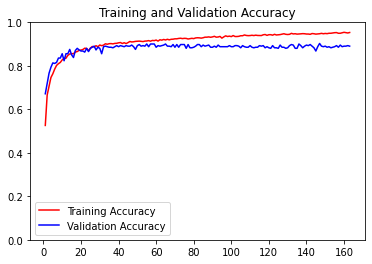

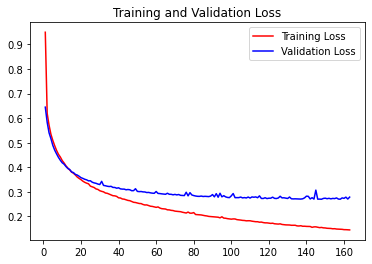

In [ ]:
"""
MODEL 1_2_VGG PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model1_2_vgg_history.history['accuracy'], model1_2_vgg_history.history['val_accuracy'], 20.0)

plot_training_validation_loss(model1_2_vgg_history.history['loss'], model1_2_vgg_history.history['val_loss'], 20.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m1_2_vgg_predicted_labels = [ int(x) for x in np.around(model1_2_vgg.predict(m1_2_test_images),0) ]

print(metrics.classification_report(m1_2_test_labels, m1_2_vgg_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m1_2_test_labels, m1_2_vgg_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m1_2_test_labels, m1_2_vgg_predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       157
           1       0.87      0.91      0.89       179

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.88       336
weighted avg       0.88      0.88      0.88       336

CONFUSION MATRIX
[[133  24]
 [ 16 163]]
AUC SCORE
0.8788741415507242


###CONCLUSIONS
The experiment led to significant improvements in terms of results and performances. 

In [ ]:
"""
MODEL SAVING
Model is saved in model folder as 'calcification_mass_pretrained_vgg2'.
"""

model1_2_vgg.save(os.path.join(MODELS_FOLDER,"calcification_mass_pretrained_vgg2.h5"))

#SUBTASK 2: PRE-TRAINED BENIGN-MALIGNANT CLASSIFICATION
Since the problem is a binary classification, we need to distinguish between two classes. Label 0 is assigned to Benign class (original labels were 1 and 3), label 1 is assigned to Malignant class (original labels were 2 and 4). It is important to analyze the balancing of the two classes so that a countermeasure to a possible unbalanced class problem can be taken.

In [ ]:
"""
PREPROCESSING
Labels are redefined: label 0 is assigned to Benign class, label 1 is assigned to 
Malignant class. Sets compositions are printed.
"""

bm_training_labels = np.array([0 if n%2==1 else 1 for n in training_labels])
bm_test_labels = np.array([0 if n%2==1 else 1 for n in test_labels])

# analyze composition of training and test set
print("TRAINING SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(bm_training_labels==0)) + 
      " (" + str(round((np.count_nonzero(bm_training_labels==0)/TRAINING_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(bm_training_labels==1)) + 
      " (" + str(round((np.count_nonzero(bm_training_labels==1)/TRAINING_SET_SIZE)*100,2)) + "%)")

print("TEST SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(bm_test_labels==0)) + 
      " (" + str(round((np.count_nonzero(bm_test_labels==0)/TEST_SET_SIZE)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(bm_test_labels==1)) + 
      " (" + str(round((np.count_nonzero(bm_test_labels==1)/TEST_SET_SIZE)*100,2)) + "%)")

TRAINING SET
Number of samples of class 0 (Benign): 1568 (58.59%)
Number of samples of class 1 (Malignant): 1108 (41.41%)
TEST SET
Number of samples of class 0 (Benign): 219 (65.18%)
Number of samples of class 1 (Malignant): 117 (34.82%)


##EXPERIMENT 2_1: FEATURE EXTRACTION FROM VGG16 AND RESNET50
The aim of this experiment is to evaluate the results of performing feature extraction from two of the most used pre-trained networks, *VGG16* and *ResNet50*. Both networks are considered without their top layers (*include_top=False*) and their weights are initialized according to the results of pre-training on *ImageNet*.  Both bases are *frozen*, so the only layers that will be trained are theones put on the top of those bases.


In [ ]:
"""
PREPROCESSING
Training and test images are normalized. Training images (and their respective labels) are 
shuffled even if classes are already randomly distributed. Validation set composition is
printed, so that a new extraction can be performed in case of unbalanced classes.
"""

m2_1_training_images = training_images / MAX_UINT16
m2_1_training_labels = bm_training_labels

m2_1_test_images = test_images / MAX_UINT16
m2_1_test_labels = bm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m2_1_training_images = m2_1_training_images[permutation]  
m2_1_training_labels = m2_1_training_labels[permutation] 

m2_1_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))
m2_1_validation_labels = m2_1_training_labels[-m2_1_validation_size:]

print("VALIDATION SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(m2_1_validation_labels==0)) + 
      " (" + str(round((np.count_nonzero(m2_1_validation_labels==0)/m2_1_validation_size)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(m2_1_validation_labels==1)) + 
      " (" + str(round((np.count_nonzero(m2_1_validation_labels==1)/m2_1_validation_size)*100,2)) + "%)")

VALIDATION SET
Number of samples of class 0 (Benign): 252 (62.84%)
Number of samples of class 1 (Malignant): 149 (37.16%)


###VGG16-BASED
*VGG16* is used as base in this experiment. A *ReLu* Dense layer is added on the top the base, and another *Sigmoid* Dense layer is used to perform classification. *Adam* is used as optimizer and Learning Rate is 1e-5. Max number of epochs is 1000, but a *Callback* with *patience=15* is used.

In [ ]:
"""
VGG16-BASED MODEL 
"""

vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

#vgg base is frozen
vgg_base.trainable=False

model2_1_vgg = models.Sequential(name="MODEL_1_VGG")
model2_1_vgg.add(vgg_base)
model2_1_vgg.add(layers.Flatten(name="FLAT_1"))
model2_1_vgg.add(layers.Dense(1024, activation="relu", name="DENSE_1"))
model2_1_vgg.add(layers.Dense(1, activation="sigmoid", name="DENSE_2"))

model2_1_vgg.summary()

Model: "MODEL_1_VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
FLAT_1 (Flatten)             (None, 8192)              0         
_________________________________________________________________
DENSE_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
DENSE_2 (Dense)              (None, 1)                 1025      
Total params: 23,105,345
Trainable params: 8,390,657
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [ ]:
"""
MODEL 2_1_VGG COMPILATION AND FITTING
Adam is used as optimizer, with Learning Rate equal to 1e-5. Max number of epochs
is 1000, Callback is used to early stop training phase. 
"""

model2_1_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2_1_vgg_history  = model2_1_vgg.fit(x=m2_1_training_images,
          y=m2_1_training_labels,
          validation_split=VALIDATION_SPLIT, 
          batch_size=DEFAULT_BATCH_SIZE,
          epochs=MAX_NUMBER_OF_EPOCHS,
          callbacks=[callback])

Epoch 1/1000
72/72 [==============================] - 6s 82ms/step - loss: 0.6782 - accuracy: 0.5790 - val_loss: 0.6289 - val_accuracy: 0.6517
Epoch 2/1000
72/72 [==============================] - 6s 80ms/step - loss: 0.6487 - accuracy: 0.5934 - val_loss: 0.6129 - val_accuracy: 0.6567
Epoch 3/1000
72/72 [==============================] - 6s 82ms/step - loss: 0.6329 - accuracy: 0.6306 - val_loss: 0.6152 - val_accuracy: 0.6642
Epoch 4/1000
72/72 [==============================] - 6s 83ms/step - loss: 0.6187 - accuracy: 0.6378 - val_loss: 0.5941 - val_accuracy: 0.6642
Epoch 5/1000
72/72 [==============================] - 6s 85ms/step - loss: 0.6182 - accuracy: 0.6307 - val_loss: 0.5945 - val_accuracy: 0.7040
Epoch 6/1000
72/72 [==============================] - 6s 85ms/step - loss: 0.5939 - accuracy: 0.6587 - val_loss: 0.6102 - val_accuracy: 0.6269
Epoch 7/1000
72/72 [==============================] - 6s 83ms/step - loss: 0.6002 - accuracy: 0.6529 - val_loss: 0.5814 - val_accuracy: 0.6667

In [ ]:
"""
MODEL 2_1_VGG RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m2_1_vgg_test_loss, m2_1_vgg_test_accuracy = model2_1_vgg.evaluate(m2_1_test_images, m2_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m2_1_vgg_test_accuracy))
print("LOSS " + str(m2_1_vgg_test_loss))

11/11 [==============================] - 1s 66ms/step - loss: 0.5878 - accuracy: 0.6845
TEST SET RESULTS
ACCURACY 0.6845238208770752
LOSS 0.5878281593322754


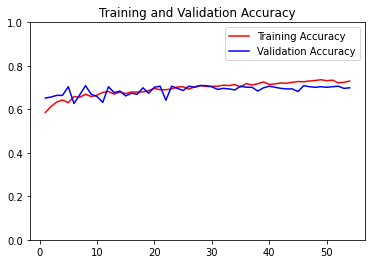

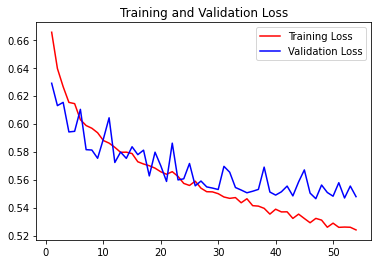

In [ ]:
"""
MODEL 2_1_VGG PLOTTING RESULTS
Accuracy and loss on the training and validation sets are plotted.
"""

plot_training_validation_accuracy(model2_1_vgg_history.history['accuracy'], model2_1_vgg_history.history['val_accuracy'], 10.0 )

plot_training_validation_loss(model2_1_vgg_history.history['loss'], model2_1_vgg_history.history['val_loss'], 10.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m2_1_vgg_predicted_labels = [ int(x) for x in np.around(model2_1_vgg.predict(m2_1_test_images),0) ]

print(metrics.classification_report(m2_1_test_labels, m2_1_vgg_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m2_1_test_labels, m2_1_vgg_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m2_1_test_labels, m2_1_vgg_predicted_labels))

              precision    recall  f1-score   support

           0       0.73      0.83      0.77       219
           1       0.56      0.42      0.48       117

    accuracy                           0.68       336
   macro avg       0.65      0.62      0.63       336
weighted avg       0.67      0.68      0.67       336

CONFUSION MATRIX
[[181  38]
 [ 68  49]]
AUC SCORE
0.6226437185341295


###RESNET50-BASED
ResNet50 is used as base in this experiment. In order to reduce the total number of parameters to be learned, a Global Pooling Layer is used instead of a Flatten one. A *ReLu* Dense layer is added on the top the base, and another *Sigmoid* Dense layer is used to perform classification. *Adam* is used as optimizer and Learning Rate is 1e-5. Max number of epochs is 1000, but a *Callback* with *patience=15* is used.

In [ ]:
"""
RESNET50-BASED MODEL 
"""

res_base = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

#res base is frozen
res_base.trainable=False

model2_1_res = models.Sequential(name="MODEL_1_RES")
model2_1_res.add(res_base)
model2_1_res.add(layers.GlobalAveragePooling2D(name="GLOB_AVG_1"))
model2_1_res.add(layers.Dense(1024, activation="relu", name="DENSE_1"))
model2_1_res.add(layers.Dense(1, activation="sigmoid", name="DENSE_2"))

model2_1_res.summary()

Model: "MODEL_1_RES"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
GLOB_AVG_1 (GlobalAveragePoo (None, 2048)              0         
_________________________________________________________________
DENSE_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
DENSE_2 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
"""
MODEL 2_1_RES COMPILATION AND FITTING
Adam is used as optimizer, with Learning Rate equal to 1e-6. Max number of epochs
is 1000, Callback is used to early stop training phase. 
"""

model2_1_res.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2_1_res_history  = model2_1_res.fit(x=m2_1_training_images,
          y=m2_1_training_labels,
          validation_split=VALIDATION_SPLIT, 
          batch_size=DEFAULT_BATCH_SIZE,
          epochs=MAX_NUMBER_OF_EPOCHS, 
          callbacks=[callback])

Epoch 1/1000
72/72 [==============================] - 8s 70ms/step - loss: 0.7247 - accuracy: 0.5259 - val_loss: 0.7009 - val_accuracy: 0.5796
Epoch 2/1000
72/72 [==============================] - 4s 58ms/step - loss: 0.7176 - accuracy: 0.5257 - val_loss: 0.6861 - val_accuracy: 0.5945
Epoch 3/1000
72/72 [==============================] - 4s 58ms/step - loss: 0.7016 - accuracy: 0.5287 - val_loss: 0.6731 - val_accuracy: 0.6194
Epoch 4/1000
72/72 [==============================] - 4s 58ms/step - loss: 0.6706 - accuracy: 0.5748 - val_loss: 0.6624 - val_accuracy: 0.6418
Epoch 5/1000
72/72 [==============================] - 4s 59ms/step - loss: 0.6667 - accuracy: 0.5843 - val_loss: 0.6522 - val_accuracy: 0.6418
Epoch 6/1000
72/72 [==============================] - 4s 59ms/step - loss: 0.6491 - accuracy: 0.6032 - val_loss: 0.6436 - val_accuracy: 0.6368
Epoch 7/1000
72/72 [==============================] - 4s 59ms/step - loss: 0.6550 - accuracy: 0.5715 - val_loss: 0.6366 - val_accuracy: 0.6443

In [ ]:
"""
MODEL 2_1_RES RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m2_1_res_test_loss, m2_1_res_test_accuracy = model2_1_res.evaluate(m2_1_test_images ,m2_1_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m2_1_res_test_accuracy))
print("LOSS " + str(m2_1_res_test_loss))

11/11 [==============================] - 1s 52ms/step - loss: 0.5637 - accuracy: 0.6994
TEST SET RESULTS
ACCURACY 0.699404776096344
LOSS 0.5636656880378723


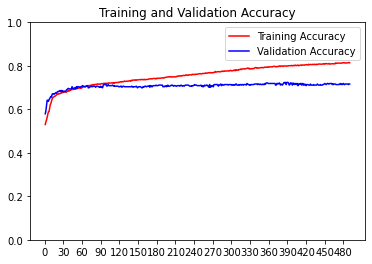

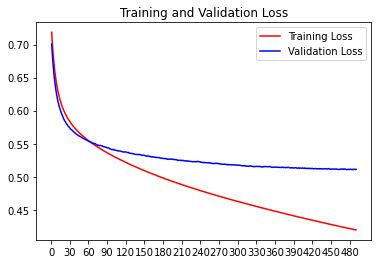

In [ ]:
"""
MODEL 2_1_RES PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model2_1_res_history.history['accuracy'], model2_1_res_history.history['val_accuracy'], 30.0)

plot_training_validation_loss(model2_1_res_history.history['loss'], model2_1_res_history.history['val_loss'], 30.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m2_1_res_predicted_labels = [ int(x) for x in np.around(model2_1_res.predict(m2_1_test_images),0) ]

print(metrics.classification_report(m2_1_test_labels, m2_1_res_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m2_1_test_labels, m2_1_res_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m2_1_test_labels, m2_1_res_predicted_labels))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       219
           1       0.57      0.59      0.58       117

    accuracy                           0.70       336
   macro avg       0.67      0.67      0.67       336
weighted avg       0.70      0.70      0.70       336

CONFUSION MATRIX
[[166  53]
 [ 48  69]]
AUC SCORE
0.6738672286617493


###CONCLUSIONS
*ResNet* is better than *VGG16* in this specific problem. However, due to the non-sequential nature of *ResNet*, it is difficult to reuse it for the next experiment.

In [ ]:
"""
MODEL SAVING
Models are saved in model folder as 'benign_malignant_pretrained_vgg1' and 
'benign_malignant_pretrained_res1'.
"""

model2_1_vgg.save(os.path.join(MODELS_FOLDER,"benign_malignant_pretrained_vgg1.h5"))
model2_1_res.save(os.path.join(MODELS_FOLDER,"benign_malignant_pretrained_res1.h5"))

##EXPERIMENT 2_2: EXTRACT ONLY FIRST LAYERS FROM VGG16
Since *ImageNet* dataset is far different from *CBIS-DDSM* dataset, an idea could be to use only the first pretrained layers of *VGG16*. As a matter of fact, they extract only the most generic features that can be reused in the current problem. The extracted layers are *frozen*, so that learned features are not modified.

In [ ]:
"""
PREPROCESSING
Training and test images are normalized. Training images (and their respective labels) are 
shuffled even if classes are already randomly distributed. Validation set composition is
printed, so that a new extraction can be performed in case of unbalanced classes.
"""

m2_2_training_images = training_images / MAX_UINT16
m2_2_training_labels = bm_training_labels

m2_2_test_images = test_images / MAX_UINT16
m2_2_test_labels = bm_test_labels

# permutation is used in order to perform the same shuffling on images and labels
permutation = np.random.RandomState(seed=SEED).permutation(TRAINING_SET_SIZE)   
m2_2_training_images = m2_2_training_images[permutation]  
m2_2_training_labels = m2_2_training_labels[permutation] 

m2_2_validation_size = int(np.floor(TRAINING_SET_SIZE*VALIDATION_SPLIT))
m2_2_validation_labels = m2_2_training_labels[-m2_2_validation_size:]

print("VALIDATION SET")
print("Number of samples of class 0 (Benign): " + str(np.count_nonzero(m2_2_validation_labels==0)) + 
      " (" + str(round((np.count_nonzero(m2_2_validation_labels==0)/m2_2_validation_size)*100,2)) + "%)")
print("Number of samples of class 1 (Malignant): " + str(np.count_nonzero(m2_2_validation_labels==1)) + 
      " (" + str(round((np.count_nonzero(m2_2_validation_labels==1)/m2_2_validation_size)*100,2)) + "%)")

VALIDATION SET
Number of samples of class 0 (Benign): 252 (62.84%)
Number of samples of class 1 (Malignant): 149 (37.16%)


###VGG16-BASED

In [ ]:
"""
VGG16-BASED MODEL 
"""

vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

vgg_base.trainable = False

model2_2_vgg = models.Sequential(name="MODEL_2_VGG")

#take only first four Convolutional blocks
for layer in vgg_base.layers[:15]:
  model2_2_vgg.add(layer)

model2_2_vgg.add(layers.Conv2D(filters=512, kernel_size=(2,2), activation="relu", kernel_initializer="he_uniform", name="CONV_1"))
model2_2_vgg.add(layers.MaxPooling2D(pool_size=(2,2), name="MAX_1"))
model2_2_vgg.add(layers.Flatten(name="FLAT_1"))
model2_2_vgg.add(layers.Dropout(0.25, name="DROP_1"))
model2_2_vgg.add(layers.Dense(1024, activation="relu", kernel_initializer="he_uniform", name="DENSE_1"))
model2_2_vgg.add(layers.Dense(1, activation="sigmoid", name="DENSE_2"))

model2_2_vgg.summary()

Model: "MODEL_2_VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       

In [ ]:
"""
CALLBACK DEFINITION
"""

callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
"""
MODEL 2_2_VGG COMPILATION AND FITTING
Adam is used as optimizer, with Learning Rate equal to 1e-6. Max number of epochs
is 1000, Callback is used to early stop training phase. 
"""

model2_2_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2_2_vgg_history  = model2_2_vgg.fit(x=m2_2_training_images,
          y=m2_2_training_labels,
          validation_split=VALIDATION_SPLIT, 
          batch_size=DEFAULT_BATCH_SIZE,
          epochs=MAX_NUMBER_OF_EPOCHS, 
          callbacks=[callback])

Epoch 1/1000
72/72 [==============================] - 6s 75ms/step - loss: 0.8210 - accuracy: 0.4964 - val_loss: 0.6363 - val_accuracy: 0.6294
Epoch 2/1000
72/72 [==============================] - 5s 72ms/step - loss: 0.7648 - accuracy: 0.5567 - val_loss: 0.6155 - val_accuracy: 0.6418
Epoch 3/1000
72/72 [==============================] - 5s 72ms/step - loss: 0.7254 - accuracy: 0.5755 - val_loss: 0.6054 - val_accuracy: 0.6517
Epoch 4/1000
72/72 [==============================] - 5s 73ms/step - loss: 0.7204 - accuracy: 0.5684 - val_loss: 0.5974 - val_accuracy: 0.6567
Epoch 5/1000
72/72 [==============================] - 5s 73ms/step - loss: 0.7271 - accuracy: 0.5743 - val_loss: 0.5921 - val_accuracy: 0.6617
Epoch 6/1000
72/72 [==============================] - 5s 75ms/step - loss: 0.6786 - accuracy: 0.6086 - val_loss: 0.5901 - val_accuracy: 0.6642
Epoch 7/1000
72/72 [==============================] - 5s 73ms/step - loss: 0.7157 - accuracy: 0.5730 - val_loss: 0.5829 - val_accuracy: 0.6567

In [ ]:
"""
MODEL 2_2_VGG RESULTS ON TEST SET
Accuracy and loss on the test set are evaluated.
"""

m2_2_vgg_test_loss, m2_2_vgg_test_accuracy = model2_2_vgg.evaluate(m2_2_test_images ,m2_2_test_labels)
print("TEST SET RESULTS")
print("ACCURACY " + str(m2_2_vgg_test_accuracy))
print("LOSS " + str(m2_2_vgg_test_loss))

11/11 [==============================] - 1s 58ms/step - loss: 0.5709 - accuracy: 0.7024
TEST SET RESULTS
ACCURACY 0.7023809552192688
LOSS 0.5709484815597534


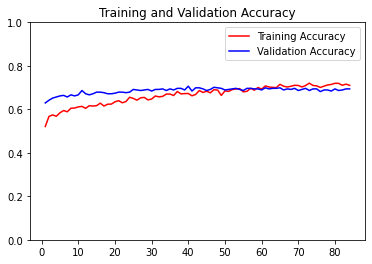

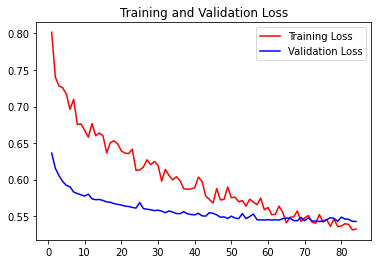

In [ ]:
"""
MODEL 2_2_VGG PLOTTING RESULTS
Accuracy and loss on the training and validations sets are plotted.
"""

plot_training_validation_accuracy(model2_2_vgg_history.history['accuracy'], model2_2_vgg_history.history['val_accuracy'], 10.0)

plot_training_validation_loss(model2_2_vgg_history.history['loss'], model2_2_vgg_history.history['val_loss'], 10.0)

In [ ]:
"""
PRINT METRICS
Confusion matrix and other metrics are printed.
"""

m2_2_vgg_predicted_labels = [ int(x) for x in np.around(model2_2_vgg.predict(m2_2_test_images),0) ]

print(metrics.classification_report(m2_2_test_labels, m2_2_vgg_predicted_labels))
print("CONFUSION MATRIX")
print(metrics.confusion_matrix(m2_2_test_labels, m2_2_vgg_predicted_labels))
print("AUC SCORE")
print(metrics.roc_auc_score(m2_2_test_labels, m2_2_vgg_predicted_labels))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       219
           1       0.59      0.49      0.53       117

    accuracy                           0.70       336
   macro avg       0.67      0.65      0.66       336
weighted avg       0.69      0.70      0.69       336

CONFUSION MATRIX
[[179  40]
 [ 60  57]]
AUC SCORE
0.6522655426765016


###CONCLUSIONS

In [ ]:
"""
SAVE THE MODEL
Best model is saved in model folder as 'benign_malignant_pretrained_res2'.
"""

model2_2_vgg.save(os.path.join(MODELS_FOLDER,"benign_malignant_pretrained_vgg2.h5"))